In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
#import torchviz
import time
import copy

import matplotlib.pyplot as plt

import ase.io

from utils.soap import compute_spherical_expansion_librascal

from utils.models import FullGapModel, SparseGapModel, PerSpeciesSparseGapModel, LinearModel
from utils.models import MixedSpeciesFullGapModel, MixedSpeciesSparseGapModel, MixedSpeciesLinearModel

torch.set_default_dtype(torch.float64)

In [2]:
torch.cuda.is_available()

True

In [3]:
n_frames = 100

frames = ase.io.read("data/elpasolites_10590.xyz", f":{n_frames}")
#methane_frames = ase.io.read("data/methane-100.xyz", f":{n_frames}")
energies = torch.tensor(np.loadtxt("data/elpasolites_10590_evpa.dat")[:n_frames])

n_train = int(0.8 * len(frames))

train_frames = frames[:n_train]
test_frames = frames[n_train:]

train_energies = energies[:n_train]
test_energies = energies[n_train:]

print(f"using {n_train} training frames")

using 80 training frames


In [4]:
global_species = set()
for frame in frames:
    global_species.update(frame.numbers)

global_species = list(map(lambda u: int(u), global_species))

HYPERS_SMALL = {
    "interaction_cutoff": 5.0,
    "max_angular": 2,
    "max_radial": 2,
    "gaussian_sigma_constant": 0.3,
    "gaussian_sigma_type": "Constant",
    "cutoff_smooth_width": 0.5,
    "radial_basis": "GTO",
    "compute_gradients": False,
    "expansion_by_species_method": "user defined",
    "global_species": global_species,
}

HYPERS_MJW = {
    "interaction_cutoff": 5.0,
    "max_angular": 3,
    "max_radial": 4,
    "gaussian_sigma_constant": 0.3,
    "gaussian_sigma_type": "Constant",
    "cutoff_smooth_width": 0.5,
    "radial_basis": "GTO",
    "compute_gradients": False,
    "expansion_by_species_method": "user defined",
    "global_species": global_species,
}

# Validate utilities

In [5]:
# import utils.gap

# def structure_sum(kernel):
#     return utils.gap.common.SumStructureKernel.apply(kernel, test_slices, train_slices)

# rand_kernel = torch.rand((len(test_slices), len(train_slices)), requires_grad=True)
# torch.autograd.gradcheck(structure_sum, rand_kernel, fast_mode=True)

# Baseline: GAP model without species combination

In [6]:
def evaluate_and_plot_model(model, name, file):
    predicted_energies_training_set = model(
        train_spherical_expansions, train_species, train_slices
    )

    predicted_energies_test_set = model(
        test_spherical_expansions, test_species, test_slices
    )

    loss_fn = torch.nn.MSELoss()
    train_loss = loss_fn(predicted_energies_training_set.squeeze(), train_energies)
    test_loss = loss_fn(predicted_energies_test_set.squeeze(), test_energies)

    train_loss *= 100 / train_energies.std()
    test_loss *= 100 / test_energies.std()

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].scatter(train_energies, predicted_energies_training_set.detach().numpy())
    x = np.linspace(train_energies.min(), train_energies.max(), 20)
    ax[0].plot(x, x, color='r')

    ax[0].set_title(f'Training set — loss = {train_loss:.3} %RMSE')
    ax[0].set_xlabel('DFT')
    ax[0].set_ylabel('Predicted')


    ax[1].scatter(test_energies, predicted_energies_test_set.detach().numpy())
    x = np.linspace(test_energies.min(), test_energies.max(), 20)
    ax[1].plot(x, x, color='r')

    ax[1].set_title(f'Test set — loss = {test_loss:.3} %RMSE')
    ax[1].set_xlabel('DFT')
    ax[1].set_ylabel('Predicted')

    fig.suptitle(name)
    fig.savefig(file, bbox_inches="tight")

In [7]:
# train_spherical_expansions, train_slices = compute_spherical_expansion_librascal(train_frames, HYPERS_SMALL)
# test_spherical_expansions, test_slices = compute_spherical_expansion_librascal(test_frames, HYPERS_SMALL)

# train_species = torch.hstack([torch.tensor(frame.numbers) for frame in train_frames])
# test_species = torch.hstack([torch.tensor(frame.numbers) for frame in test_frames])

# Linear model

In [8]:
# linear = LinearModel(lambdas=[1e-6])
# linear.fit(train_spherical_expansions, train_species, train_slices, train_energies)

# evaluate_and_plot_model(
#     linear, 
#     f"Linear model",
#     "linear.pdf",
# )

# Full GAP

In [9]:
# full_gap = FullGapModel(zeta=2, lambdas=[1e-1])
# full_gap.fit(train_spherical_expansions, train_species, train_slices, train_energies)

# evaluate_and_plot_model(
#     full_gap, 
#     f"Full GAP model",
#     "full-gap.pdf",
# )

# Sparse GAP

In [10]:
# n_support = 100

# sparse_gap = SparseGapModel(n_support=n_support, zeta=2, lambdas=[1e-1])
# sparse_gap.fit(train_spherical_expansions, train_species, train_slices, train_energies)

# evaluate_and_plot_model(
#     sparse_gap, 
#     f"Sparse GAP model — {n_support} GAP support point",
#     "sparse-gap.pdf",
# )

### Sparse GAP, one model per central atom species

In [11]:
# n_support = {
#     species: 5 for species in global_species
# }

# per_species_sparse_model = PerSpeciesSparseGapModel(
#     n_support, 
#     zeta=2, 
#     lambdas=[1e-3], 
#     jitter=1e-10
# )
# per_species_sparse_model.fit(train_spherical_expansions, train_species, train_slices, train_energies)

# evaluate_and_plot_model(
#     per_species_sparse_model, 
#     f"Sparse model per species — {sum(n_support.values())} GAP support point",
#     "basic-sparse-per-species.pdf",
# )

In [12]:
# # # plot computational graph on a smaller dataset
# small_hypers = copy.deepcopy(HYPERS_SMALL)
# small_hypers["max_angular"] = 1
# small_hypers["max_radial"] = 1
# small_hypers["global_species"] = [6, 1]


# for i in methane_frames:
#     i.cell = np.array([50,50,50])
#     i.center(axis = (0,1,2), about  = (25, 25, 25))
# small_train_frames = methane_frames[2:4]
# small_test_frames = methane_frames[:2]


# small_train_energies = torch.tensor([f.info["energy"] for f in small_train_frames])

# small_train_spherical_expansions, small_train_slices = compute_spherical_expansion_librascal(
#     small_train_frames, small_hypers
# )
# small_train_species = torch.hstack([torch.tensor(frame.numbers) for frame in small_train_frames])

# small_test_spherical_expansions, small_test_slices = compute_spherical_expansion_librascal(
#     small_test_frames, small_hypers
# )
# small_test_species = torch.hstack([torch.tensor(frame.numbers) for frame in small_test_frames])

# small_n_support = {1: 10, 6: 10}

# small_model = MixedSpeciesLinearModel(
#     global_species, 
#     n_pseudo_species=2, 
#     lambdas=[1e-3, 1e-6],
#     optimizable_weights=True,
# )
# small_model.fit(
#     small_train_spherical_expansions, 
#     small_train_species, 
#     small_train_slices, 
#     small_train_energies
# )

# torchviz_params = {}
# for l, sph in small_test_spherical_expansions.items():
#     sph.requires_grad_(True)
#     torchviz_params[f"sph l={l}"] = sph

# #for s, w in small_model.model.weights.items():
# #    w.requires_grad_(True)
# #    torchviz_params[f"weight species={s}"] = w
# torchviz_params[f"weight species=1"] = small_model.model.weights

# result = small_model(small_test_spherical_expansions, small_test_species, small_test_slices)

# torchviz.make_dot(result, params=torchviz_params)

In [13]:
# for w in small_model.model.weights:
#     print(w)

# Combining species

In [14]:
class AtomisticDataset(torch.utils.data.Dataset):
    def __init__(self, frames, hypers, energies):
        self.spherical_expansions = []
        for frame in frames:
            se, slices = compute_spherical_expansion_librascal([frame], hypers)
            self.spherical_expansions.append(se)
        
        self.species = [torch.tensor(frame.numbers) for frame in frames]
        self.energies = energies

    def __len__(self):
        return len(self.spherical_expansions)

    def __getitem__(self, idx):
        return self.spherical_expansions[idx], self.species[idx], self.energies[idx]

In [15]:
def collate_data_cpu(data):
    spherical_expansion = {
        lambda_: torch.vstack([d[0][lambda_] for d in data])
        for lambda_ in data[0][0].keys()
    }

    species = torch.hstack([d[1] for d in data])
    energies = torch.vstack([d[2] for d in data])

    slices = []
    start = 0
    for d in data:
        stop = start + d[1].shape[0]
        slices.append(slice(start, stop))
        start = stop

    return spherical_expansion, species, slices, energies

def collate_data_gpu(data):
    spherical_expansion, species, slices, energies = collate_data_cpu(data)

    spherical_expansion = {
        lambda_: se.to(device='cuda') for lambda_, se in spherical_expansion.items()
    }

    return spherical_expansion, species.to(device='cuda'), slices, energies.to(device='cuda')

# Optimization loop using GPU

In [16]:
train_dataset = AtomisticDataset(train_frames, HYPERS_MJW, train_energies)
test_dataset = AtomisticDataset(test_frames, HYPERS_MJW, test_energies)

In [17]:
N_PSEUDO_SPECIES = 4
UPDATE_SUPPORT_POINTS = False

# Full kernel, optimize everything with gradients
mixed_species_model = MixedSpeciesFullGapModel(
    global_species, 
    n_pseudo_species=N_PSEUDO_SPECIES, 
    zeta=1, 
    lambdas=[1e-3],
    optimizable_weights=True,
    random_initial_weights=True,
    detach_support_points=True,
)

# # Full kernel, optimize species with gradients, weights with linear algebra
# mixed_species_model = MixedSpeciesFullGapModel(
#     global_species, 
#     n_pseudo_species=N_PSEUDO_SPECIES, 
#     zeta=1, 
#     lambdas=[1e-1, 1e-6],
#     optimizable_weights=False,
# )

# # Sparse kernel, optimize everything with gradients
# mixed_species_model = MixedSpeciesSparseGapModel(
#     global_species, 
#     n_support=100,
#     n_pseudo_species=N_PSEUDO_SPECIES, 
#     zeta=1, 
#     lambdas=[1e-3, 1e-6],
#     optimizable_weights=True,
# )

# # Sparse kernel, optimize species with gradients, weights with linear algebra
# mixed_species_model = MixedSpeciesSparseGapModel(
#     global_species, 
#     n_support=100,
#     n_pseudo_species=N_PSEUDO_SPECIES, 
#     zeta=1, 
#     lambdas=[1e-1, 1e-6],
#     optimizable_weights=False,
# )

# # Linear regression, optimize everything with gradients
# mixed_species_model = MixedSpeciesLinearModel(
#     global_species, 
#     n_pseudo_species=N_PSEUDO_SPECIES, 
#     lambdas=[1e-3, 1e-6],
#     optimizable_weights=True,
# )

In [18]:
device = "cuda"
# device = "cpu"

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=512, 
    shuffle=True,
    collate_fn=collate_data_gpu if device == "cuda" else collate_data_cpu
)

# dataloader without batching for the initial fit
train_dataloader_no_batch_cpu = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=len(train_dataset), 
    shuffle=False,
    collate_fn=collate_data_cpu
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=1, 
    shuffle=False,
    collate_fn=collate_data_gpu if device == "cuda" else collate_data_cpu
)


In [19]:
def loss_optimizer(predicted, actual, regularizer, weights):
    loss = torch.linalg.norm(predicted - actual) ** 2
    # regularize the loss, full dataset std
    loss += regularizer / torch.std(train_energies) * torch.linalg.norm(weights) ** 2

    # TODO alternative: batch std
    # loss += regularizer / torch.std(actual) * torch.linalg.norm(weights) ** 2
    return loss

def loss_mae(predicted, actual):
    return torch.mean(torch.abs(predicted - actual))

In [20]:
if mixed_species_model.optimizable_weights:
    with torch.no_grad():
        # initialize the weights to a nice value using fit
        for spherical_expansions, species, slices, energies in train_dataloader_no_batch_cpu:
            # we want to intially train the model on all frames, to ensure the
            # support points come from the full dataset. This happens on CPU, the
            # move to GPU is happening below
            assert len(slices) == len(train_frames)
            mixed_species_model.fit(spherical_expansions, species, slices, energies)


if not mixed_species_model.optimizable_weights:
    # we can not use batches if we are training with linear algebra, we need to
    # have all training frames available
    assert train_dataloader.batch_size >= len(train_frames)

mixed_species_model.to(device=device)

if mixed_species_model.optimizable_weights:
    regularizer = 2e-3
else:
    regularizer = 0

lrate = 0.1
optimizer = torch.optim.AdamW(mixed_species_model.parameters(), lr=lrate)

In [21]:
from datetime import datetime
fname = 'tr'+str(n_train)+'_ts1000_rg'+str(regularizer)+'_opttrue_sparsep_noupdate_lr_mean_lr'+str(lrate)

f = open(fname,'a+')
f.write(f"#epoch loss mae_test(eV/structure) {datetime.now()}\n")
f.close()
f = open(fname,'a+')

all_losses = []
for epoch in range(100):
    epoch_start = time.time()

    if UPDATE_SUPPORT_POINTS:
        # to update the support points, we need to move to CPU to be able to fit
        # all training data at once in memory
        mixed_species_model.to(device="cpu")
        for spherical_expansions, species, slices, _ in train_dataloader_no_batch_cpu:
            assert len(slices) == len(train_frames)
            # use `select_again=True` to re-select the same number of support
            # points. this might make convergence slower, but maybe able to
            # reach a lower final loss?
            #
            # with `select_again=False`, the environments selected in the first
            # fit above are used as support points
            mixed_species_model.update_support_points(
                spherical_expansions, species, select_again=False
            )
        mixed_species_model.to(device=device)

    for spherical_expansions, species, slices, energies in train_dataloader:
        def single_step():
            optimizer.zero_grad()
           
            if not mixed_species_model.optimizable_weights:
                mixed_species_model.fit(spherical_expansions, species, slices, energies)
                
            predicted = mixed_species_model(spherical_expansions, species, slices)    

            loss = loss_optimizer(predicted, energies, regularizer, mixed_species_model.model.weights)
            loss.backward()

            return loss

        loss = optimizer.step(single_step)
        all_losses.append(loss.item())

    epoch_time = time.time() - epoch_start
    if epoch % 1 == 0:
        with torch.no_grad():
            predicted = []
            for spherical_expansions, species, slices, energies in test_dataloader:
                predicted.append(mixed_species_model(spherical_expansions, species, slices))

            predicted = torch.vstack(predicted)
            mae = loss_mae(predicted.cpu(), test_dataset.energies)
            f.write(f"{epoch} {loss.item():.4} {mae:.4} {datetime.now()}\n")
            f.close()
            f = open(fname,'a+')

        print(f"epoch {epoch} took {epoch_time:.4}s, optimizer loss={loss.item():.4}, test mae={mae:.4}")

epoch 0 took 0.3083s, optimizer loss=5.065e+07, test mae=465.7
epoch 1 took 0.2928s, optimizer loss=1.906e+07, test mae=245.6
epoch 2 took 0.2935s, optimizer loss=5.522e+06, test mae=120.1
epoch 3 took 0.2939s, optimizer loss=1.484e+06, test mae=46.24
epoch 4 took 0.2931s, optimizer loss=2.751e+05, test mae=11.51
epoch 5 took 0.2934s, optimizer loss=2.236e+04, test mae=41.96
epoch 6 took 0.2905s, optimizer loss=1.723e+05, test mae=71.68
epoch 7 took 0.2926s, optimizer loss=4.958e+05, test mae=94.81
epoch 8 took 0.2913s, optimizer loss=8.673e+05, test mae=112.0
epoch 9 took 0.2905s, optimizer loss=1.204e+06, test mae=123.5
epoch 10 took 0.29s, optimizer loss=1.454e+06, test mae=129.8
epoch 11 took 0.2918s, optimizer loss=1.589e+06, test mae=131.4
epoch 12 took 0.2922s, optimizer loss=1.607e+06, test mae=129.0
epoch 13 took 0.2893s, optimizer loss=1.526e+06, test mae=123.3
epoch 14 took 0.288s, optimizer loss=1.374e+06, test mae=115.0
epoch 15 took 0.2901s, optimizer loss=1.182e+06, test

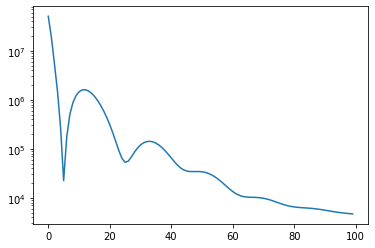

In [22]:
plt.semilogy(all_losses)

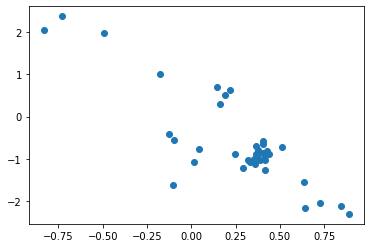

In [23]:
species_combining_matrix = mixed_species_model.alchemical.combining_matrix.detach().cpu().numpy()

plt.scatter(species_combining_matrix[:, 0], species_combining_matrix[:, 1])

In [24]:
predicted = []
for spherical_expansions, species, slices, energies in test_dataloader:
    predicted.append(mixed_species_model(spherical_expansions, species, slices))

predicted = torch.vstack(predicted)

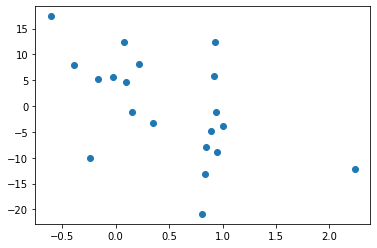

In [25]:
plt.scatter(test_dataset.energies, predicted.cpu().detach())